This notebook along with corresponding github repository is concerned on my solution of Kontur 2023 internship task.


The task was to find a substring in a document that matches to the label given for each text. This is a classical NER task, only with custom labels. I used [SpaCy](https://spacy.io/) library to solve it which I think is very good instrument for uncomplicated NER problems.

##Git stuff


In [ ]:
! git clone 'https://github.com/aassegai/Kontur23'
import os
os.chdir('Kontur23')

Cloning into 'Kontur23'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (223/223), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 223 (delta 80), reused 162 (delta 37), pack-reused 0
Receiving objects: 100% (223/223), 1.38 MiB | 6.27 MiB/s, done.
Resolving deltas: 100% (80/80), done.


## Imports

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
! pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 74.5 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=25bd46053bbd78c208f40eb40905ec0ee4cf9fbfba166eecaa7e9d3a357d74a3
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt


In [ ]:
! pip install spacy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install spacy[transformers]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 110.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import spacy
from spacy import displacy
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
'''
Sometimes when GPU runtime is used an error appears during spacy installation
NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968
This piece of code fixes this problem
'''
import locale
if str(locale.getpreferredencoding()) != 'UTF-8':
    def getpreferredencoding(do_setlocale = True):
      return "UTF-8"
    locale.getpreferredencoding = getpreferredencoding

In [ ]:
! python -m spacy download ru_core_news_sm

2023-04-22 03:07:51.363507: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 44.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


## Preprocessing


Firstly, we need to preprocess data. There are 2 main ways to do this:


*   Drop some items from train dataset which have inadequate text or annotation, too long annotation etc.
*   Preprocess text and annotation itself: remove punctuation and stopwords, normalize words (lower-case, lemmatize)

We will look at both cases further.



In [ ]:
train_df = pd.read_json('./data/raw/train.json')
test_df = pd.read_json('./data/raw/test.json')

Set validation set size close to the test set size.

In [ ]:
train_df, val_df = train_test_split(train_df, test_size=0.2)
val_df.set_index('id', inplace=True)

In [ ]:
train_df

,id,text,label,extracted_part
541,63089751,№ п/п Дополнительная информация 1 Наименование...,обеспечение исполнения контракта,"{'text': ['Участник закупки, с которым заключа..."
1339,689132062,Извещение о проведении электронного аукциона д...,обеспечение гарантийных обязательств,{'text': ['Размер обеспечения гарантийных обяз...
1632,485503185,Версия с 04.07.2022 года У Т В Е Р Ж Д А Ю «Го...,обеспечение гарантийных обязательств,"{'text': [''], 'answer_start': [0], 'answer_en..."
261,578621849,Идентификационный код закупки: 222633005012063...,обеспечение исполнения контракта,{'text': ['Размер обеспечение исполнения контр...
47,574654977,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
...,...,...,...,...
1785,627854560,ДОГОВОР ПОСТАВКИ ТМЦ № 100-10-05/______ г. Кра...,обеспечение гарантийных обязательств,"{'text': [''], 'answer_start': [0], 'answer_en..."
334,112910092,КОНТРАКТ<1> № ___ <2> на поставку продуктов пи...,обеспечение исполнения контракта,{'text': ['Обеспечение исполнения настоящего К...
160,627430961,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
931,496586369,ЧАСТЬ II ТОМ 2 «Информационная карта аукциона ...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения Догов...


### Label disbalance check

We obviously need to know if the labels are balanced in train dataset because if they're not (which is barely possible in case of 2 labels but still) we'll need to solve this problem with some specific methods like making custom loss function, distance-based pretraining of feature extractor (transformer in our case) etc.

In [ ]:
idx_to_drop = [idx for idx, item in train_df.iterrows() if len(item.extracted_part['text']) == 0]

<Axes: xlabel='label', ylabel='Count'>

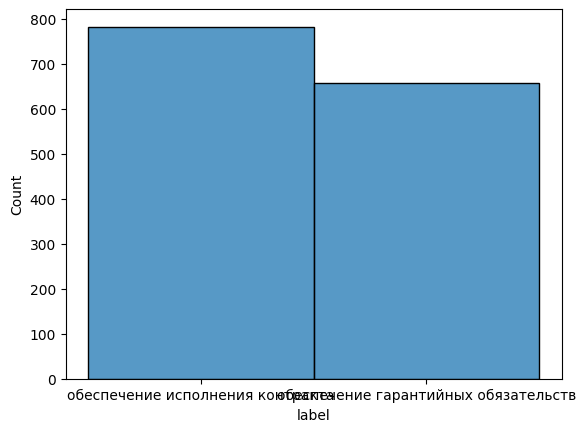

In [ ]:
data_check = train_df.drop(idx_to_drop)
sns.histplot(data=data_check.label)

First class is smaller than second. However, difference is not that large to care about it so we will leave it as it is.

### Text lengths check

Let's look at the texts and annotations lengths both in words and symbols. The reason of checking  symbol length is that the documents we have are either scanned from paper or were text documents and could have been copied improperly.

In [ ]:
text_lens_in_words = [len(item.text.split()) for _, item in train_df.iterrows()]
text_lens_in_symbols = [len(item.text) for _, item in train_df.iterrows()]

segment_lens_in_words = [len(item.extracted_part['text'][0].split()) for _, item in train_df.iterrows()]
segment_lens_in_symbols = [len(item.extracted_part['text'][0]) for _, item in train_df.iterrows()] 

<Axes: ylabel='Count'>

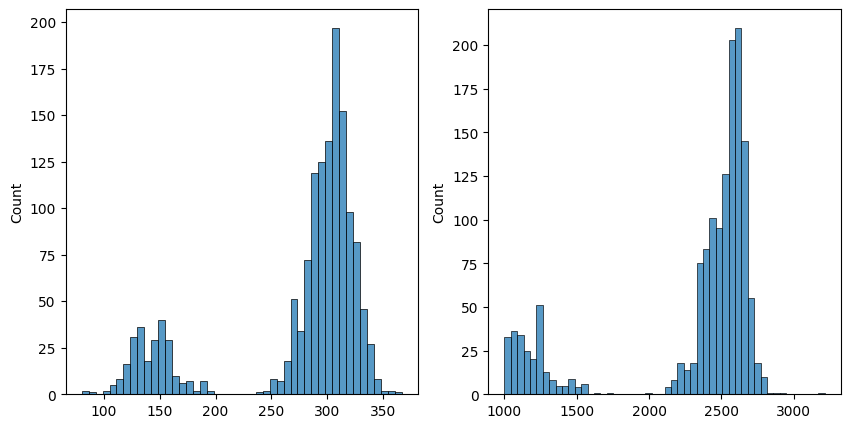

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.histplot(ax=ax[0], data=text_lens_in_words)
sns.histplot(ax=ax[1], data=text_lens_in_symbols)

<Axes: ylabel='Count'>

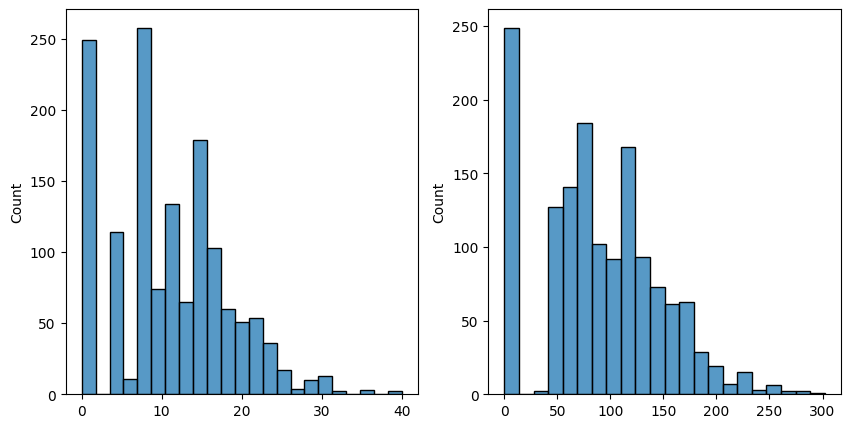

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.histplot(ax=ax[0], data=segment_lens_in_words)
sns.histplot(ax=ax[1], data=segment_lens_in_symbols)

As we can see, length distributions in words and symbols are pretty the same for both texts and annotations. There are no inadequate lengths but some pretty there are long annotations, let's look at them. 

In [ ]:
for idx, item in train_df.iterrows():
    if len(item.extracted_part['text'][0].split()) > 30:
        print(item.extracted_part['text'][0]) 

Субподрядчик в качестве обеспечения надлежащего исполнения гарантийных обязательств по Договору предоставляет Подрядчику право на удержание в общем размере 2% от цены Договора (включая НДС), указанной в пункте 3.1. Договора (далее Гарантийное удержание).
Подрядчик в срок до 10 (десяти) рабочих дней предоставляет Заказчику обеспечение гарантийных обязательств в соответствии с частью 2.2 статьи 96 Закона о контрактной системе в размере 1 процент начальной (максимальной) цены контракта/цены контракта, что составляет 62 577 рублей 00 копеек.
Подрядчик обязан предоставить Заказчику обеспечение гарантийных обязательств на сумму ________ руб. (_______________ рублей __ копеек), что составляет 3 % от цены Договора, в форме _____________ (независимой гарантии или путем внесения денежных средств
Требования к независимым гарантиям, предоставляемые в качестве обеспечения заявок, гарантийных обязательств и исполнения Договора Обеспечение исполнения Договора требуется в размере 10% (Десять) проценто

Actually nothing criminal here, some long annotations that we will not drop from the dataset.

### Texts preprocessing

Let's analyze the texts preprocessing. The common way is lower-case the text, remove the punctuation, stopwords etc, possibly normalize words.

In our case punctuaton removal is very risky thing because we are solving the NER task and significant amount of entities contain punctuation, underlining and mathematical symbols. Same thing for stopwords: almost every single entity contatins more than one stopword (prepositions, unions etc.).

Also stopwords removal is not actually worth it because of transformer attention mechanism which treat them like not important.

De-capitalising words works good with -uncased models. Since all the models used are -cased it is pretty useless. It also can be bad for prediction quality because most of the documents contain proper nouns like names, cities and abbreviations and it is important to have them with a capital letter especially in russian language. 

Normalizing words (lemmatizing/stemming) is good decision for linear models with large vocabulary. However, since transformers are used here and they use BPE, normalization does not make lot of sense.



In [ ]:
# this module is used for preprocessing dataset with all options mentioned above
from src.data_preprocessing.data_preprocessor import DataPreprocessor
data_preprocessor = DataPreprocessor()

Based on experiments results (see preprocessing_tests.ipynb) it is better to train the model with no preprocessing at all. 

*    Punctuation removal drops F1 almost twice. It probably happens not only because of their presence in the entities but also because of complex substrings that have punctuation inside (№____, 1234.56 etc.).

*    Stopwords removal drops quality for 0.05-0.07 F1-score. Therefore we are not doing that. 

*    Word normalization as mentioned earlier is useless and affects validation scores badly too.

*    Lower-casing words did it better on uncased models as expected. But best performing model is cased, and de-capitalisation drops 0.01-0.03 F1-score.

In [ ]:
train_df = data_preprocessor(train_df, set_index_to_id=True)

  0%|          | 0/1439 [00:00<?, ?it/s]

In [ ]:
train_df

,text,label,extracted_part
id,,,
63089751,№ п/п Дополнительная информация 1 Наименование...,обеспечение исполнения контракта,"{'answer_start': [1251], 'answer_end': [1405],..."
689132062,Извещение о проведении электронного аукциона д...,обеспечение гарантийных обязательств,"{'answer_start': [1308], 'answer_end': [1378],..."
485503185,Версия с 04.07.2022 года У Т В Е Р Ж Д А Ю «Го...,обеспечение гарантийных обязательств,"{'answer_start': [0], 'answer_end': [0], 'text..."
578621849,Идентификационный код закупки: 222633005012063...,обеспечение исполнения контракта,"{'answer_start': [1309], 'answer_end': [1421],..."
574654977,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,"{'answer_start': [1303], 'answer_end': [1368],..."
...,...,...,...
627854560,ДОГОВОР ПОСТАВКИ ТМЦ № 100-10-05/______ г. Кра...,обеспечение гарантийных обязательств,"{'answer_start': [0], 'answer_end': [0], 'text..."
112910092,КОНТРАКТ<1> № ___ <2> на поставку продуктов пи...,обеспечение исполнения контракта,"{'answer_start': [1263], 'answer_end': [1332],..."
627430961,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,"{'answer_start': [1280], 'answer_end': [1326],..."


## Model training

Here we will do a bit more data preprocessing for using it in SpaCy model. 

There are some items that have blank annotations and spacy does bot allow that in dataset so we lose some training data. There are also some items in test set that should have not subtext to extract. 

In case of training data that's ok because we lose some training items but they're pretty useless since they have no consistent annotations.
 
And in case of test set our model either should not see any substrings to extract or the label of the extracted part will not match the requested label so the problem is solved too.

In [ ]:
for idx, row in train_df.iterrows():
    train_df.loc[idx].extracted_part['label'] = row.label

for idx, row in val_df.iterrows():
    val_df.loc[idx].extracted_part['label'] = row.label

In [ ]:
from src.data_preprocessing.prepare_bin import prepare_bin
prepare_bin(train_df)
prepare_bin(val_df, mode='val')
prepare_bin(test_df, mode='test')

0it [00:00, ?it/s]

249 items had blank annotation and were skipped


0it [00:00, ?it/s]

58 items had blank annotation and were skipped


0it [00:00, ?it/s]

0 items had blank annotation and were skipped


Why am I using spacy? Same reason i'd use the catboost instead of making decision trees with my hands. It works good, it is fast and easy to use. Since the task I'm solving is simple and straighforward there is no reason to make model by myself because no specific solutions are needed and stable instrument will be better.

Unfortunately, spacy models cannot be properly trained in jupyter-like notebooks without weird-looking code and probably some limitations. Instead of this we can use [SpaCy CLI](https://spacy.io/api/cli) which is used as python script.

To use it we should firstly make the config file with training parameters. It also defines the model architecture. The best parameters I found are:


*   (ai-forever) sberbank-ai/ruBert-base transformer
*   initial learning rate $5 * 10^{-5}$ 
*   128 batch size
*   dropout 0.35
*   L2-regularization with 0.03 weight*   early stopping at 1200 evaluation steps without progress or at 15 training epochs

Full user configuration can be seen in spacy_cfg.cfg file.

I tested several transformers (DeepPavlov Bert and Roberta, sberai Bert/Roberta in base and large variants).Sberai ruBert-base was the best with not large margin from DeepPavlov ruBert-base-cased, but provided more stability while training. Large Bert and roberta from sber are very hard to put inside the kaggle/colab GPU and can be used only on very small batch sizes that makes training unbearably long. DeepPavlovs roberta trains longer than Bert and gives the same result minding other things being equal.  




 Script lower takes the file with user options and fills it with remaining parameters needed for training.

In [ ]:
! python -m spacy init fill-config ./src/model/spacy_cfg.cfg config.cfg

2023-04-22 07:14:43.238863: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


Next script fits the model with given train and validation sets. Set --gpu-id to -1 for CPU training, to 0 for GPU.

In [ ]:
! python -m spacy train config.cfg --output ./ --paths.train ./train_dataset.spacy --paths.dev ./val_dataset.spacy --gpu-id 0

2023-04-22 07:14:55.901687: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ℹ Saving to output directory: .
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2023-04-22 07:15:02,908] [INFO] Set up nlp object from config
[2023-04-22 07:15:02,919] [INFO] Pipeline: ['transformer', 'ner']
[2023-04-22 07:15:02,922] [INFO] Created vocabulary
[2023-04-22 07:15:02,923] [INFO] Finished initializing nlp object
Some weights of the model checkpoint at sberbank-ai/ruBert-base were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint 

## Model evaluation

Let's load the best model spacy saved and predict the entities in the test dataset.

In [ ]:
nlp_ner = spacy.load("model-best")

In [ ]:
from src.model.predict import predict_entities
preds = [predict_entities(nlp_ner, row.text, row.label) for _, row in tqdm(test_df.iterrows())]

0it [00:00, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (560 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
test_df['extracted_part'] = preds
test_dict = test_df.to_dict(orient='rows')

<ipython-input-77-d582a622d45e>:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  test_dict = test_df.to_dict(orient='rows')


In [ ]:
import json
with open('predictions.json', 'w', encoding='utf8') as output:
    json.dump(test_dict, output, ensure_ascii=False)

In [ ]:
test_df.head(10)

,id,text,label,extracted_part
0,762883279,МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание ус...,обеспечение исполнения контракта,"{'answer_start': [1283], 'answer_end': [1393],..."
1,311837655,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,"{'answer_start': [1291], 'answer_end': [1337],..."
2,540954893,Идентификационный код закупки: 222633005300163...,обеспечение исполнения контракта,"{'answer_start': [1300], 'answer_end': [1412],..."
3,274660397,Идентификационный код закупки: 222631202689463...,обеспечение исполнения контракта,"{'answer_start': [1312], 'answer_end': [1424],..."
4,732742591,Идентификационный код закупки: 222637800031163...,обеспечение исполнения контракта,"{'answer_start': [1314], 'answer_end': [1426],..."
5,102997495,Идентификационный код закупки: 222635001882363...,обеспечение исполнения контракта,"{'answer_start': [1304], 'answer_end': [1416],..."
6,355078344,Идентификационный код закупки: 222635001881663...,обеспечение исполнения контракта,"{'answer_start': [1315], 'answer_end': [1427],..."
7,803828087,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,"{'answer_start': [1312], 'answer_end': [1377],..."
8,285525147,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,"{'answer_start': [1291], 'answer_end': [1357],..."
9,321195392,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,"{'answer_start': [1295], 'answer_end': [1360],..."


Let's look at some examples of model predictions. Spacy has beautiful render to show the entities inside the text.

In [ ]:
test_df.loc[195].label

'обеспечение гарантийных обязательств'

In [ ]:
doc = nlp_ner(test_df.text.loc[195])

colors = {"обеспечение исполнения контракта": "#FF2D00", "обеспечение гарантийных обязательств": "#36FF00"}
options = {"colors": colors} 

spacy.displacy.render(doc, style="ent", options=options, jupyter=True)

In [ ]:
test_df.loc[111].label

'обеспечение исполнения контракта'

In [ ]:
doc = nlp_ner(test_df.text.loc[111])

colors = {"обеспечение исполнения контракта": "#FF2D00", "обеспечение гарантийных обязательств": "#36FF00"}
options = {"colors": colors} 

spacy.displacy.render(doc, style="ent", options=options, jupyter=True)

In [ ]:
test_df.loc[243].label

'обеспечение гарантийных обязательств'

In [ ]:
doc = nlp_ner(test_df.text.loc[243])

colors = {"обеспечение исполнения контракта": "#FF2D00", "обеспечение гарантийных обязательств": "#36FF00"}
options = {"colors": colors} 

spacy.displacy.render(doc, style="ent", options=options, jupyter=True)

Looks like it founds entities fine! What if there should not be any entity?

In [ ]:
test_df.loc[266].label

'обеспечение гарантийных обязательств'

In [ ]:
doc = nlp_ner(test_df.text.loc[266])

colors = {"обеспечение исполнения контракта": "#FF2D00", "обеспечение гарантийных обязательств": "#36FF00"}
options = {"colors": colors} 

spacy.displacy.render(doc, style="ent", options=options, jupyter=True)

It just does not see it. Good.